<html><font size=6><B>3rd laboratory exercise</B><BR>
    <BR><B>Link prediction </B></BR>
    Nanos Georgios 03400144 (DSML)
    </font></html>

In [1]:
%matplotlib inline

import matplotlib
import networkx as nx
import random
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd
from sklearn.cluster import SpectralClustering
import itertools
from rdflib import Graph as RDFGraph
from rdflib.extras.external_graph_libs import rdflib_to_networkx_graph
import networkx as nx
from networkx import Graph as NXGraph
import matplotlib.pyplot as plt
import statistics
import collections
import warnings
warnings.filterwarnings('ignore')

<html><font size=4><B>1. Graph construction and preparation for link prediction</B></font>
    <li><B>1(i).</B>Use το dataset <a href="http://konect.cc/networks/dbpedia-similar/"> Similarities (DBpedia)</a>, 
to construct the undirected graph $G$ <a href="https://dl.acm.org/doi/10.1145/2487788.2488173">[1]</a>,<a href="https://link.springer.com/chapter/10.1007/978-3-540-76298-0_52">[2]</a>.Graph nodes represent Wikipedia pages and edges have a similar relationship to each other. In page <a href="http://konect.cc/networks/dbpedia-similar/"> KONECT (DBpedia)</a> 
you can find information on the properties of the graph.</a><BR>
        <B><U>Indication:</U></B> You can programmatically check if the dataset contains duplicates of the edges in the same or reverse order (eg edges (a, b) and (b, a)), and take this observation into account where if necessary, in question 2.<BR></html>

In [2]:
with open("out.dbpedia-similar") as file_operator:
     edges = file_operator.read().splitlines()
list0 = []
list1 = []
for i in range(len(edges)):
     list0.append(edges[i].split(' ')[0])
     list1.append(edges[i].split(' ')[1])
     df = pd.DataFrame({'from':list0, 'to':list1})
G0 = nx.from_pandas_edgelist(df, 'from', 'to', create_using=nx.Graph())

In [3]:
#Check if graph is directed
print(nx.is_directed(G0))

False


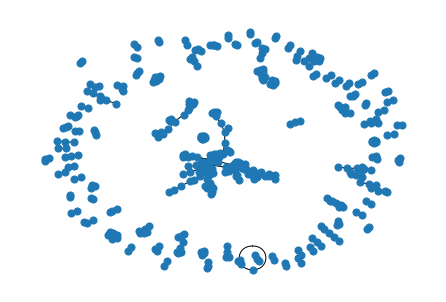

In [4]:
#visualize Wikipedia data 
nx.draw(G0, node_size=50)
plt.show()

In [5]:
df

,from,to
0,1,2
1,1,3
2,1,4
3,1,5
4,2,3
...,...,...
560,423,424
561,423,425
562,426,427
563,428,429


In [6]:
duplicate = False
for i in range(len(df)):
    search_from = df['from'][i]
    search_to = df['to'][i]
    for j in range(i+1, len(df)):
        if(df['from'][j] == search_to and df['to'][j] == search_from):
            duplicate = True
            print('Duplicate : from {} to {}' .format(df['from'][j], df['to'][j]))
if(duplicate == True):
    print('There are Duplicates')
else:
    print('There arent any Duplicates')
    

There arent any Duplicates


 <li><B>1(ii).</B> Display the number of nodes, the number of edges, the average number of nodes, and the number of connected components for $G$.</li><BR>

In [7]:
def find_degree(G):
    return np.array([v for (u, v) in nx.degree(G)])

In [8]:
initial_node_count=  len(G0.nodes)         
initial_connected_components= nx.number_connected_components(G0) 
print('Initial number of nodes is: ', initial_node_count)
print('Initial number of edges is: ', len(G0.edges))
print('Mean node degree is: ', find_degree(G0).mean())
print('Initial number of connected components is: ', initial_connected_components)

Initial number of nodes is:  430
Initial number of edges is:  565
Mean node degree is:  2.627906976744186
Initial number of connected components is:  95


In [9]:
G_adj = nx.to_numpy_matrix(G0)
G_adj =np.array(G_adj)

<li> <B> 1 (iii). </B> Calculate the total of unconnected pairs on the graph using the adjacency matrix. Also give their number. Note that the graph is non-directional and you do not have to go through the entire neighborhood table. </li> <BR>

In [10]:
unconnected_pairs_set = set()
unconnected_pairs = 0
for i in range(len(G_adj)):
    for j in range(i+1, len(G_adj)):
        if(G_adj[i][j] == 0):
            unconnected_pairs+=1
            unconnected_pairs_set.add((i,j))
print('The number of unconnected pairs is: ', unconnected_pairs)
#print(unconnected_pairs_set)

The number of unconnected pairs is:  91671


<li> <B> 1 (iv). </B> Calculate the total number of removable edges that can be removed from the graph without splitting the graph (ie the number of cohesive components should be to remain unchanged). Note: Also check that removing an edge does not reduce the number of nodes (unless there is a separate file with only nodes in the dataset). Also give the number of removable edges that can be removed under these conditions. </li> <BR>

In [11]:
#create a copy of the initial graph
H = G0.copy()

In [12]:
removable_edges = 0
removable_edges_set = set()
for i in range(initial_node_count):
    for j in range(i+1, initial_node_count):
        if H.has_edge(str(i), str(j)):
            H.remove_edge(str(i), str(j))
            if(initial_node_count == len(H.nodes) and initial_connected_components == nx.number_connected_components(H)):
                removable_edges+=1
                removable_edges_set.add((i,j))
            else:
                H.add_edge(str(i), str(j))

print('The number of edges that can be removed from the graph without splittin is: ', removable_edges)
#print(removable_edges_set)


The number of edges that can be removed from the graph without splittin is:  229


<li> <B> 1 (va). </B> Construct a dataframe that combines the answers to questions 1 (iii) and 1 (iv) (unconnected + removables). Use the $ link $ variable to get a value of 1 or 0 depending on the link or not. This dataframe gathers the positive and negative samples for the prediction of future connections (link: target variable). <BR>
    <li> <B> 1 (vb). </B> Construct the graph $ G '$ resulting from subtracting from the graph $ G $ the edges of query 1 (iv). <BR>
    <li> <B> 1 (vc). </B> Display the number of nodes, the number of edges, the average number of nodes, and the number of connected components for the $ G '$ graph. < / li> <BR>

1(va)

In [13]:
#set to list, and seperate the nodes linked for removable edges set
s_rem = list(removable_edges_set)
f_rem = []
t_rem = []
for i in range(removable_edges):
    f_rem.append(s_rem[i][0])
    t_rem.append(s_rem[i][1])

#set to list, and seperate the nodes linked for unconnected nodes set
s_un = list(unconnected_pairs_set)
f_un = []
t_un = []
for i in range(unconnected_pairs):
    f_un.append(s_un[i][0])
    t_un.append(s_un[i][1])

In [14]:
f = f_rem + f_un
t = t_rem + t_un
l = []
for i in range(len(f)):
    if i < len(f_rem):
        l.append(1)
    else:
        l.append(0)

In [15]:
df_rem = pd.DataFrame({'from node0' : f_rem, 'to node1' : t_rem})
df_un = pd.DataFrame({'from node0' : f_un, 'to node1' : t_un})
df_rem['link'] = 1
df_un['link'] = 0
print(df_rem)
print(df_un)
dffg = pd.DataFrame({'node0-node1' : s_rem + s_un,'from node0' : f, 'to node1' : t, 'link' : l}) 


     from node0  to node1  link
0           333       342     1
1           226       230     1
2            20        25     1
3           338       342     1
4           342       343     1
..          ...       ...   ...
224          68        90     1
225          78        85     1
226         334       341     1
227         105       108     1
228          68        96     1

[229 rows x 3 columns]
       from node0  to node1  link
0             266       351     0
1             342       418     0
2             109       365     0
3             381       392     0
4             132       420     0
...           ...       ...   ...
91666         204       304     0
91667         243       298     0
91668         280       288     0
91669         190       359     0
91670          63       255     0

[91671 rows x 3 columns]


In [16]:
dffg

,node0-node1,from node0,to node1,link
0,"(333, 342)",333,342,1
1,"(226, 230)",226,230,1
2,"(20, 25)",20,25,1
3,"(338, 342)",338,342,1
4,"(342, 343)",342,343,1
...,...,...,...,...
91895,"(204, 304)",204,304,0
91896,"(243, 298)",243,298,0
91897,"(280, 288)",280,288,0
91898,"(190, 359)",190,359,0


1(vb)

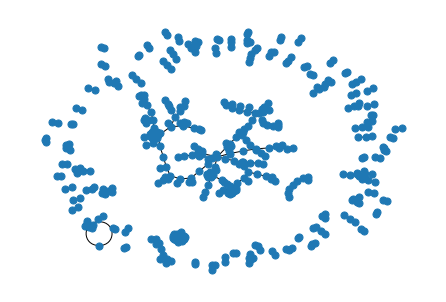

In [17]:
#visualize Wikipedia with removed edges 
nx.draw(H, node_size=50)
plt.show()

1(vc)

In [18]:
node_count=  len(H.nodes)         
connected_components= nx.number_connected_components(H) 
print('Number of nodes of H graph is: ', initial_node_count)
print('Number of edges of H graph is: ', len(H.edges))
print('Mean node degree of H graph is: ', find_degree(H).mean())
print('Number of connected components is: ', initial_connected_components)

Number of nodes of H graph is:  430
Number of edges of H graph is:  336
Mean node degree of H graph is:  1.5627906976744186
Number of connected components is:  95


<html><font size=4><B>2. Introduction to similarity-based metrics for Link prediction</B></font><BR><BR>
     <li> The metric <B>
Jaccard Coefficient (JC) </B> of nodes $ {u} $ and $ {v} $ is defined as $\frac{|\Gamma(u) \cap \Gamma(v)|}{|\Gamma(u) \cup \Gamma(v)|}$, where ${\Gamma(u)}$ 
is the set of adjacent nodes of the node ${u}$.  <B></B>
<li> The metric <B> Preferential Attachment (PA) </B> of nodes $ u $ and $ v $ is defined as $ | \Gamma (u) | | \Gamma (v) | $, where $ \Gamma (u) $ is the set of adjacent nodes of $ u $. </li>
        <li> The metric <B>Resource Allocation (RA)</B> of nodes $u$ and $v$ is defined as $\sum_{w \in \Gamma(u) \cap \Gamma(v)} \frac{1}{|\Gamma(w)|}$, where $\Gamma(u)$ is the set of its neighboring nodes τοof $u$.</li><BR><BR>
    <li><B>2(i).</B> 
For the graph $ G '$, constructed in query 1 (vb), calculate the metric <B> Jaccard Coefficient (JC)</B>.  <u><a href="https://networkx.org/documentation/stable/reference/algorithms/link_prediction.html?highlight=link%20prediction"> 
Use the implemented function of NetworkX software.<a></u> <BR><BR>
    <li><B>2(ii). 
    </B> Give the $k$ edges with the highest metric value of $JC$, where your $k$ $ID$ $mod$ $ 10 $. 
        For comparison between different metrics it is preferable to find the $ k $ dominant links, as metrics return a different range of values.</li><BR>
    <li><B>2(iii). </B>Determine $ Precision $, $ Recall $, and $ Accuracy $ to measure the performance of the $ JC $ metric and represent graphs for threshold values: $0.1$, $0.15$, $0.25$, $0.5$, $1.0$.  <BR><BR>
    $Precision=\frac{TP}{TP+FP}$<BR>
    $Recall=\frac{TP}{TP+FN}$</li> 
    $Accuracy=\frac{TP+TN}{TP+FN+TN+FP}$</li><BR><BR>
       

2(i)

AM = 0340144, k = AM mod 10 -> k = 4

In [20]:
preds = nx.jaccard_coefficient(H)
jac = []
for p in preds:
    jac.append(list(p))
    print(p)


('242', '146', 0.0)
('242', '63', 0.0)
('242', '166', 0.0)
('242', '406', 0.0)
('242', '410', 0.0)
('242', '414', 0.0)
('242', '189', 0.0)
('242', '67', 0.0)
('242', '176', 0.0)
('242', '21', 0.0)
('242', '130', 0.0)
('242', '407', 0.0)
('242', '429', 0.0)
('242', '419', 0.0)
('242', '50', 0.0)
('242', '209', 0.0)
('242', '56', 0.0)
('242', '378', 0.0)
('242', '34', 0.0)
('242', '257', 0.0)
('242', '270', 0.0)
('242', '171', 0.0)
('242', '258', 0.0)
('242', '61', 0.0)
('242', '118', 0.0)
('242', '179', 0.0)
('242', '287', 0.0)
('242', '204', 0.0)
('242', '356', 0.0)
('242', '23', 0.0)
('242', '382', 0.0)
('242', '297', 0.0)
('242', '427', 0.0)
('242', '26', 0.0)
('242', '292', 0.0)
('242', '213', 0.0)
('242', '231', 0.0)
('242', '114', 0.0)
('242', '319', 0.0)
('242', '84', 0.0)
('242', '2', 0.0)
('242', '230', 0.0)
('242', '373', 0.0)
('242', '300', 0.0)
('242', '245', 0.0)
('242', '194', 0.0)
('242', '33', 0.0)
('242', '137', 0.0)
('242', '83', 0.0)
('242', '232', 0.0)
('242', '228',

2(ii)

In [21]:
k = 4
jac_preds = []
for i in range(len(jac)):
    jac_preds.append(jac[i][2])
jac_preds.sort(reverse=True)
jac_sorted = sorted(jac, key=lambda x:x[2], reverse = True)

print('Printing k = {} edges with the highest jaccard value' .format(k))
print()
for i in range(k):
    print('The edge from {} to {} has {} jaccard value' .format(jac_sorted[i][0], jac_sorted[i][1], jac_sorted[i][2]))

Printing k = 4 edges with the highest jaccard value

The edge from 166 to 164 has 1.0 jaccard value
The edge from 67 to 66 has 1.0 jaccard value
The edge from 67 to 65 has 1.0 jaccard value
The edge from 407 to 408 has 1.0 jaccard value


2(iii)

In [22]:
dffg

,node0-node1,from node0,to node1,link
0,"(333, 342)",333,342,1
1,"(226, 230)",226,230,1
2,"(20, 25)",20,25,1
3,"(338, 342)",338,342,1
4,"(342, 343)",342,343,1
...,...,...,...,...
91895,"(204, 304)",204,304,0
91896,"(243, 298)",243,298,0
91897,"(280, 288)",280,288,0
91898,"(190, 359)",190,359,0


In [23]:
def JCfunction(threshold_jc):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    preds = nx.jaccard_coefficient(H)
    for u, v, p in (list(preds)):
        if p>=threshold_jc:
            if((int(u), int(v)) in s_rem) or ((int(v), int(u)) in s_rem):
                tp+=1
            else:
                fp+=1
        else:
            if((int(u), int(v)) in s_rem) or ((int(v), int(u)) in s_rem):
                fn+=1
            else:
                tn+=1
#    print(tp, tn, fn, fp)
    recall_jc = tp/(tp+fn)
    precision_jc = tp/(tp+fp)
    accuracy_jc = (tp+tn)/(tp+fn+tn+fp)
#   print('recall : ', recall_jc)
#   print('precision : ', precision_jc)
#   print('accuracy : ', accuracy_jc)
    return recall_jc, precision_jc, accuracy_jc

In [24]:
#0.1
print('Threshold 0.1\n')
recall_jac, precision_jc, accuracy_jc = JCfunction(0.1)
print('recall: {} \nprecision: {} \naccuracy: {} \n' .format(recall_jac, precision_jc, accuracy_jc))
#0.15
print('Threshold 0.15\n')
recall_jac, precision_jc, accuracy_jc = JCfunction(0.15)
print('recall: {} \nprecision: {} \naccuracy: {} \n' .format(recall_jac, precision_jc, accuracy_jc))
#0.25
print('Threshold 0.25\n')
recall_jac, precision_jc, accuracy_jc = JCfunction(0.25)
print('recall: {} \nprecision: {} \naccuracy: {} \n' .format(recall_jac, precision_jc, accuracy_jc))
#0.5
print('Threshold 0.5\n')
recall_jac, precision_jc, accuracy_jc = JCfunction(0.5)
print('recall: {} \nprecision: {} \naccuracy: {} \n' .format(recall_jac, precision_jc, accuracy_jc))
#1.0
print('Threshold 1.0\n')
recall_jac, precision_jc, accuracy_jc = JCfunction(1)
print('recall: {} \nprecision: {} \naccuracy: {} \n' .format(recall_jac, precision_jc, accuracy_jc))

Threshold 0.1

recall: 0.7074235807860262 
precision: 0.30623818525519847 
accuracy: 0.9952774755168662 

Threshold 0.15

recall: 0.6986899563318777 
precision: 0.32193158953722334 
accuracy: 0.995582154515778 

Threshold 0.25

recall: 0.6812227074235808 
precision: 0.33548387096774196 
accuracy: 0.9958433079434168 

Threshold 0.5

recall: 0.6069868995633187 
precision: 0.41369047619047616 
accuracy: 0.9968770402611534 

Threshold 1.0

recall: 0.5545851528384279 
precision: 0.47924528301886793 
accuracy: 0.9973884657236126 



<html><font size=4><B>3.
Predict links based on similarity-based metrics</B></font>    
        <li><B>3(i).</B> Suggest at least one method, to explore and express through the NumPy or SciPy or Pandas packages the correlation between the values ​​of the metrics <B>Jaccard Coefficient</B>, <B>Preferential Attachment</B>, <B>Resource Allocation</B> 
for the reduced graph $G'$.
     <li><B>3(ii).</B> 
Work on a <B> <U> copy </U> </B> of the dataframe you made in query 1 (va) (unconnected+removables). Create a column with the edges of the graph and set it as the index of the dataframe. In the dataframe you will add as columns the values ​​of the metrics (<B> Jaccard Coefficient </B>, <B> Preferential Attachment </B>, <B> Resource Allocation </B>) for the reduced graph $G'$.</li>   </font></html>
    
    |       | link  |Jacc.Coeff.|Pr.Attachment| Resource Allocation|
    |-------|-------|-----------|-------------|--------------------|
    |(1, 6) |  0    |  0.333333 |     32      |    0.700000        |
    |(1, 46)|  0    |  0.200000 |      8      |    0.166667        |

3(i)

One type of correlation is Linear Correlation, which calculates the linearity between variables or characteristic data. If the relationship between the two features is closer to a linear function then the absolute value of the correlation coefficient is greater. One measure is the Pearson correlation, in which the correlation of two vectors x, y is calculated. The process by which the linear function that best describes the correlation between the features and is mentioned above is called linear regression. Using the scipy library and the command: "scipy.stats.linregress (x, y)" we can apply the linear regression method to two vectors x, y.

A second type of correlation is the ranking correlation, which compares the classes or classifications of data related to two variables or data characteristics. If the orderings of two vectors are similar, then their correlation is strong. Via the scipy library: "scipy.stats.rankdata (x)", "scipy.stats.rankdata (y)". The Spearman rank-to-class correlation coefficient is a non-parametric measure of the monotonicity of the relationship between two data sets. Unlike the Pearson correlation, the Spearman correlation does not assume that both datasets are normally distributed "scipy.stats.spearmanr (x, y)".

3(ii)

In [25]:
#create a copy of the original dataframe
dfg = pd.DataFrame.copy(dffg)

In [26]:
preds_jac = nx.jaccard_coefficient(H)
jac = []
for u, v, p in preds_jac:
    jac.append(p)
dfg['Jacc. Coeff.'] = jac

preds_pref = nx.preferential_attachment(H)
pref = []
for u, v, p in preds_pref:
    pref.append(p)
dfg['Pr. Attachment'] = pref

preds_res = nx.resource_allocation_index(H)
res = []
for u, v, p in preds_res:
    res.append(p)
dfg['Resource Allocation'] = res

In [27]:
nodes = []
for i in range(len(dfg)):
    u = dfg['from node0'][i]
    v = dfg['to node1'][i]
    nodes.append([u,v])

In [28]:
dfg['node0-node1'] = nodes
#dfg = dfg.drop(columns="from node0")
#dfg = dfg.drop(columns="to node1")
dfg = dfg[['node0-node1','link', 'Jacc. Coeff.', 'Pr. Attachment', 'Resource Allocation']]
dfg = dfg.set_index('node0-node1')


In [29]:
dfg

,link,Jacc. Coeff.,Pr. Attachment,Resource Allocation
node0-node1,,,,
"[333, 342]",1,0.0,2,0.0
"[226, 230]",1,0.0,4,0.0
"[20, 25]",1,0.0,2,0.0
"[338, 342]",1,0.0,4,0.0
"[342, 343]",1,0.0,2,0.0
...,...,...,...,...
"[204, 304]",0,0.0,3,0.0
"[243, 298]",0,0.0,1,0.0
"[280, 288]",0,0.0,3,0.0


<li><B>3(iiiα).</B> Use the Random Forest Classifier and the dataframe copy you made in query 3 (ii) to provide connections. 
<li><B>3(iiiβ).</B> Give ($A.M$ $mod$ $10$) first predictions and the $accuracy$ of the model. </li>
<li><B>3(iiiγ).</B> Calculate the probability that the nodes will be connected ($1$,$47$) based on your model. </li>  

3(iiia)

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
 
X = dfg.iloc[:,1:]        #features, uncomment and complete
y = dfg.iloc[:,:1:]          #target, uncomment and complete

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0) #uncomment and complete

In [31]:
dfg

,link,Jacc. Coeff.,Pr. Attachment,Resource Allocation
node0-node1,,,,
"[333, 342]",1,0.0,2,0.0
"[226, 230]",1,0.0,4,0.0
"[20, 25]",1,0.0,2,0.0
"[338, 342]",1,0.0,4,0.0
"[342, 343]",1,0.0,2,0.0
...,...,...,...,...
"[204, 304]",0,0.0,3,0.0
"[243, 298]",0,0.0,1,0.0
"[280, 288]",0,0.0,3,0.0


In [32]:
classifier = RandomForestClassifier()   

from sklearn.preprocessing import MinMaxScaler 
mm_scaler = MinMaxScaler() 
X_train_scaled = mm_scaler.fit_transform(X_train)
X_test_scaled = mm_scaler.transform(X_test)

parameters = {'n_estimators' : [10,50,100], 'max_depth' : [5, 10, 15]} 
model = GridSearchCV(classifier, param_grid = parameters) 

In [33]:
model.fit(X_train_scaled, y_train)      #train the model, uncomment and complete

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [5, 10, 15],
                         'n_estimators': [10, 50, 100]})

In [34]:
print(model.best_params_)
predictions = model.predict(X_test_scaled)       #uncomment
print("Accuracy: ", accuracy_score(y_test, predictions))

{'max_depth': 5, 'n_estimators': 10}
Accuracy:  0.997519042437432


3(iiib)

In [35]:
#AM = 0340144
k = 4
for i in range(k):
    print('The predictions is: {} and the real value is: {}' .format(predictions[i], y_test['link'][i]))

The predictions is: 0 and the real value is: 0
The predictions is: 0 and the real value is: 0
The predictions is: 0 and the real value is: 0
The predictions is: 0 and the real value is: 0


3(iiic)

In [36]:
#find index for node 1 and node 47
for i in range(len(X)):
    if X.index[i] == [1, 47]: indx = i
print(indx)

75161


In [37]:
e = X_test.iloc[5143:5144, :]

In [38]:
predict_proba = model.predict_proba(X) 

In [39]:
predict_proba[indx]

array([0.99497701, 0.00502299])

<html><font size=4><B>4. 
Provide embedding links based on random walks (Random Walks) </B></font><BR><BR>
    <li><B>4(i).</B> 
Export the $ G '$ graph resulting from edge removal. 
Use the algorithm for this purpose <B>Node2vec</B> <a href="https://cs.stanford.edu/~jure/pubs/node2vec-kdd16.pdf">[3]</a>.
The algorithm maps the graph nodes via random walks (biased 2nd order random walks) in a low dimensional space 
maintaining their proximity to each other.
        <BR>
To select the parameters: 
            <li>p - random walk parameter p that determines the probability “1/p” in the source node, </li>
                <li>q - random walk parameter q that determines the probability of “1 / q” moving to a node away from the source node, </li>
                 <li>dimensions - # dimensions of Node2Vec embeddings, </li>
                     <li>num_walks - # of walks, </li>
                         <li>walk_length - random walk length, </li>
                             <li>window_size -
context window size for the Word2Vec algorithm, </li><li>num_iter - total epochs, </li>
            <li>workers - num of workers for Word2Vec,</li>
           use:   </html>
   
                   

 |   p   |   q   | dimensions|  num_walks  |walk_length |window_size|        workers            |
 |-------|-------|-----------|-------------|------------|-----------|---------------------------|
 |  1.0  |  1.0  |  128      |     10      |    80      |     10    |multiprocessing.cpu_count()|

In [40]:
from node2vec.edges import AverageEmbedder

In [41]:
#install node2vec with conda / pip
from node2vec import Node2Vec   #uncomment
import multiprocessing          #uncomment

#generate walks
node2vec_walker = Node2Vec(H, dimensions=128, walk_length=80, num_walks=10 ,workers=4, p=1.0,q=1.0 )

#train node2vec model
n2v_model = node2vec_walker.fit(window=10 , min_count=1)

Generating walks (CPU: 2): 100%|██████████| 3/3 [00:09<00:00,  3.16s/it]


<html><font>
    <li><B>4(ii).</B> 
Apply the Random Forest Classifier algorithm to predict the connections.</li><BR>
    <li><B>4(iii).</B> 
Calculate the accuracy ($ accuracy $) of the model. </li><BR></font></html>

4(ii)&4(iii)

In [42]:
dffg

,node0-node1,from node0,to node1,link
0,"(333, 342)",333,342,1
1,"(226, 230)",226,230,1
2,"(20, 25)",20,25,1
3,"(338, 342)",338,342,1
4,"(342, 343)",342,343,1
...,...,...,...,...
91895,"(204, 304)",204,304,0
91896,"(243, 298)",243,298,0
91897,"(280, 288)",280,288,0
91898,"(190, 359)",190,359,0


In [43]:
#x = [(n2v_model.wv[str(i)]+n2v_model.wv[str(j)]) for i,j in zip(df_with_target_var['node_1'], df_with_target_var['node_2'])]
x = [(n2v_model.wv[(i)]+n2v_model.wv[(j)]) for i,j in zip(dffg['from node0'], dffg['to node1'])]
y = dfg.iloc[:,:1:] 

In [44]:
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state = 0)  #uncomment and complete

In [45]:
#uncomment whole cell
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

classifier = RandomForestClassifier(max_depth=2, random_state=0) 
classifier.fit(X_train, y_train)   #uncomment and complete
predictions = classifier.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, predictions))

Accuracy:  0.997519042437432


<html><font size=4><B><U>Bibliography:</U></B><BR></font>
<a href="https://dl.acm.org/doi/10.1145/2487788.2488173">[1]	Jérôme Kunegis. KONECT – The Koblenz Network Collection. In Proc. Int. Conf. on World Wide Web Companion, pages 1343–1350, 2013.</a><BR>
<a href="https://link.springer.com/chapter/10.1007/978-3-540-76298-0_52">[2]	Sören Auer, Christian Bizer, Georgi Kobilarov, Jens Lehmann, Richard Cyganiak, and Zachary Ives. DBpedia: A nucleus for a web of open data. In Proc. Int. Semant. Web Conf., pages 722–735, 2008.<BR>
<a href="https://cs.stanford.edu/~jure/pubs/node2vec-kdd16.pdf">[3] A. Grover, J. Leskovec, Node2vec: Scalable Feature Learning for Networks. ACM KDD, 2016.</a><BR>
 <a href="https://proceedings.neurips.cc/paper/2013/file/9aa42b31882ec039965f3c4923ce901b-Paper.pdf">[4] T.Mikolov, I.Sutskever, K.Chen, G.S.Corrado and J.Dean, Distributed representations of words and phrases and their compositionality. In NIPS, 2013.</a><BR></font></html>